# Feature Extraction
We did literature review on a few papers related to the usage of IMU sensor on detecting surface bumps or textures, such as roads:
- [Sattar, Shahram & Li, Songnian & Chapman, Michael. (2018). Road Surface Monitoring Using Smartphone Sensors:A Review. Sensors. 18. 3845. 10.3390/s18113845.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6263868/pdf/sensors-18-03845.pdf)
- [Wen, Wan. (2008). Road Roughness Detection by Analysing IMU Data.](http://www.diva-portal.org/smash/get/diva2:1064977/FULLTEXT01.pdf)
- [Ld, Nhac & Nguyen, Nhan & Nguyen, Thi-Hau & Nguyen, Ha-Nam. (2018). Vehicle Mode and Driving Activity Detection Based on Analyzing Sensor Data of Smartphones. Sensors. 18. 1036. 10.3390/s18041036.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5948751/pdf/sensors-18-01036.pdf)

Popular and useful (tested) features include:

**Time domain**
- Mean
- Standard Deviation
- Skewness
- Kurtosis

**Frequency domain**
- Power Spectral Density (PSD)

Each of the above features are taken with respect to a single series, that is, 128 data points from our dataset. At the end of this script, we would like to store our engineered features into a python dictionary for readability. For the (later) training stage, we unpack into a numpy matrix for efficient vectorised implementation and training.

For PSD, we split the range of frequencies into 5 equal bands, hence creating 5 features for PSD.

**Terminology**

- Sample - a single data point
- Series - 128 sample points

In [19]:
# Install necessary packages
# windows command
!py -m pip install tabulate 
# pls use below for Unix OSes (Mac, Linux distros)
# !pip install tabulate

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [20]:
# import libraries
import pandas as pd
import numpy as np
from scipy.signal import welch
from tabulate import tabulate
import matplotlib.pyplot as plt

# location of files
data_file = './data/X_test.csv'

In [21]:
# import data & labels
df_X_test = pd.read_csv('./data/X_test.csv')

As from our (previous) EDA, orientation values are presented in quaternion form. This is not an intuitive way of representing the orientation of the robot. Hence we convert quaternion values to euler angles. We also remove the original quaternion values. Euler angles are made up of roll, pitch and yaw.

<center>
    <img src='./img/euler.png' width="600" height="400">
    Figure 1: Illustration of row, pitch and yaw angles.
</center>

In [22]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

quat = df_X_test.iloc[:,3:7].values
euler_angles = np.zeros([quat.shape[0],3])
for i in range(quat.shape[0]):
    euler_angles[i,:] = quaternion_to_euler(quat[i,0],quat[i,1],quat[i,2],quat[i,3])
print("Shape of euler_angles:",euler_angles.shape)
print('Angles below are in radians.')
print(tabulate(euler_angles[0:5],headers=['Row','Pitch','Yaw'],tablefmt='psql',numalign='right'))

Shape of euler_angles: (488448, 3)
Angles below are in radians.
+---------+------------+---------+
|     Row |      Pitch |     Yaw |
|---------+------------+---------|
| 2.84473 | -0.0142537 |  3.0916 |
| 2.84443 | -0.0144106 |  3.0918 |
| 2.84424 | -0.0146579 | 3.09198 |
| 2.84442 | -0.0147122 | 3.09209 |
| 2.84492 | -0.0144342 | 3.09208 |
+---------+------------+---------+


In [23]:
m = df_X_test.shape[0]//128

df_X_test_pruned = df_X_test.iloc[:,7:13]
preserved_keys = list(df_X_test_pruned.keys())
print('Total # of series (128 data points ea):',m)

# combine euler angles with remaining columns & reshape array into [series_id][time_steps][(old)feature]
modified_data = np.hstack((df_X_test_pruned.values,euler_angles)).reshape([m,128,-1])
new_keys = list(df_X_test_pruned.keys())+(['Row','Pitch','Yaw'])
print('modified_data shape:',modified_data.shape)
print('First 5 samples:')
print(tabulate(modified_data[0,0:5,:3],headers=new_keys[0:3],tablefmt='psql',numalign='right'))
print(tabulate(modified_data[0,0:5,3:6],headers=new_keys[3:6],tablefmt='psql',numalign='right'))
print(tabulate(modified_data[0,0:5,6:9],headers=new_keys[6:9],tablefmt='psql',numalign='right'))

Total # of series (128 data points ea): 3816
modified_data shape: (3816, 128, 9)
First 5 samples:
+----------------------+----------------------+----------------------+
|   angular_velocity_X |   angular_velocity_Y |   angular_velocity_Z |
|----------------------+----------------------+----------------------|
|           -0.0065237 |           -0.0010714 |             -0.02739 |
|             -0.11396 |             0.083987 |             -0.06059 |
|            -0.080518 |              0.11486 |            -0.037177 |
|             0.070067 |              0.03382 |            -0.035904 |
|              0.15205 |            -0.029016 |            -0.015314 |
+----------------------+----------------------+----------------------+
+-------------------------+-------------------------+-------------------------+
|   linear_acceleration_X |   linear_acceleration_Y |   linear_acceleration_Z |
|-------------------------+-------------------------+-------------------------|
|                 0.100

We will now generate hand-crafted features. Let us initialise an empty np array and group the data into a 3d array of series. While this may appear as a seemingly huge feature set, it is still much less than the raw dataset. Since we had 9 original features (Euler) and we are generating 9 new features for each old feature, this creates 81 features. We will group same type of features together (e.g. mean - columns 0:9, std dev - columns 9:18).

The 9 features are mean, std dev, skewness, std dev, PSD-A (0-40Hz), PSD-B (41-80Hz), PSD-C (81-120Hz), PSD-D (121-1600Hz), PSD-E (161-200Hz)

In [24]:
# generate empty feature array
features = np.zeros([m,9*(len(preserved_keys)+3)])
print('Features matrix shape:',features.shape)

Features matrix shape: (3816, 81)


## Mean

In [25]:
for i in range(m):
    series = modified_data[i,:,:]
    features[i,0:9] = np.mean(series,axis=0)

## Standard Deviation

In [26]:
for i in range(m):
    series = modified_data[i,:,:]
    features[i,9:18] = np.std(series,axis=0)

## Skewness

In [27]:
for i in range(m):
    series = modified_data[i,:,:]
    features[i,18:27] = np.std(series,axis=0)

## Kurtosis

In [28]:
for i in range(m):
    series = modified_data[i,:,:]
    features[i,27:36] = np.std(series,axis=0)

## Power Spectral Density
We decompose each original input feature into 5 total PSD band powers, yielding 9*5 = 45 PSD features.

In [29]:
for i in range(m):
    if(i%500==0):
        print('PSD processing @ {}...'.format(i))
    series = modified_data[i,:,:]
    for col in range(series.shape[1]):
        psd = welch(modified_data[i,:,col],fs=400)
        psd_len = len(psd[0])
        part = int((1/5)*psd_len)
        features[i,36+0*9+col] = np.sum(psd[1][:part])
        features[i,36+1*9+col] = np.sum(psd[1][part*1:part*2])
        features[i,36+2*9+col] = np.sum(psd[1][part*2:part*3])
        features[i,36+3*9+col] = np.sum(psd[1][part*3:part*4])
        features[i,36+4*9+col] = np.sum(psd[1][part*4:part*5])
print('Complete.')

PSD processing @ 0...
PSD processing @ 500...
PSD processing @ 1000...
PSD processing @ 1500...
PSD processing @ 2000...
PSD processing @ 2500...
PSD processing @ 3000...
PSD processing @ 3500...
Complete.


## Save new features as csv file

In [30]:
print('Final feature matrix shape:',features.shape)

# save new feature matrix
try:
    np.savetxt('./data/feature_extraction_kaggle.csv',features,delimiter=',')
except Exception as e:
    print('Unable to save file!',end=' ')
    print(e)

Final feature matrix shape: (3816, 81)


## Z-Scoring

In [13]:
features -= features.mean(axis=0)
features /= np.std(features,axis=0)

## Co-variance matrix
<hr>
The $d \times d$ co-variance matrix is defined as:

$$
\Sigma \ =  \ \frac{1}{n} \sum_{i=1}^n x_ix_i^T \ = \  \frac{1}{n} X^TX
$$

with the $n \times d$ data matrix:

$$
X = 
\left[ 
\begin{array}{cccc}
- x_1^T -
\\ 
 \vdots
 \\
- x_n^T -
\end{array} 
\right]
$$

The data variance along j-dim is:
$$
\Sigma_{jj} = \sum_{i=1}^n x_{i(j)}^2
$$

The data co-variance along j-dim and l-dim is :
$$
\Sigma_{jl} = \sum_{i=1}^n x_{i(j)}x_{i(l)}
$$

Compute the co-variance matrix $\Sigma$.


In [14]:
Sigma = features.T.dot(features) / features.shape[0]
print(Sigma.shape)
print(Sigma)

(81, 81)
[[ 1.          0.38908604 -0.39289712 ...  0.08324946  0.15654487
   0.0203629 ]
 [ 0.38908604  1.         -0.99705689 ... -0.0610498  -0.0425886
   0.00402912]
 [-0.39289712 -0.99705689  1.         ...  0.06050595  0.04157091
  -0.00334332]
 ...
 [ 0.08324946 -0.0610498   0.06050595 ...  1.          0.71235648
  -0.013139  ]
 [ 0.15654487 -0.0425886   0.04157091 ...  0.71235648  1.
  -0.0058255 ]
 [ 0.0203629   0.00402912 -0.00334332 ... -0.013139   -0.0058255
   1.        ]]


## Principal directions
<hr>

The principal directions $U=[u_1,u_2]$ are given by the eigenvalue decomposition (EVD) of the co-variance matrix $\Sigma$:

$$
\Sigma = U S U^T
$$


In [15]:
def EVD(X):
    s, U = np.linalg.eig(X)
    idx = s.argsort()[::-1] # decreasing order
    return s[idx], U[:,idx]

s, U = EVD(Sigma) # s = indiv variance, U each column represents an eigenvector of the principle component unit 1
#print(s)
#print(U)


## Main principal directions
<hr>
Data variations are captured by each principal direction. We will use the first k principal directions that capture e.g. 90% of total variance:
$$
\frac{\sum_{l=1}^k S_{ll}}{\sum_{l=1}^d S_{ll}} \geq 0.9
$$

k= 15
captured variance= (0.9062793905136328-1.2067174630319546e-34j)


C:\Users\pohyk\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pohyk\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\text.py:1787: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))


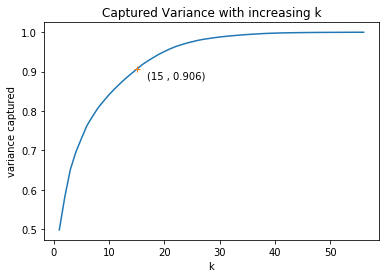

In [16]:
k = 0
var = 0
var_recorded_each_k = []
k_list = []
def select(k,s,var,var_recorded_each_k):
    tot_var = np.sum(s)
    while var < .9:
        k += 1
        var = np.sum(s[:k])/ tot_var 
    return k,var

def capturedvariance(k_list,s,var_recorded_each_k, var = 0):
    while var < .9999:
        k_list.append(len(k_list)+1)
        var = np.sum(s[:len(k_list)]/np.sum(s))
        var_recorded_each_k.append(var)
    ax = plt.plot(k_list, var_recorded_each_k)
    plt.title('Captured Variance with increasing k')
    plt.xlabel('k')
    plt.ylabel('variance captured')
    plt.plot(k_list[14],var_recorded_each_k[14],'+')
    plt.annotate('({} , {:.3f})'.format(k_list[14],np.abs(var_recorded_each_k[14])),xy=(k_list[14],var_recorded_each_k[14]), xytext=(10,-10), textcoords='offset points')
    plt.show()

k,var = select(k,s,var,var_recorded_each_k)
print('k=',k)
print('captured variance=',var)
capturedvariance(k_list,s,var_recorded_each_k)

## Save PCA features

In [17]:
# pca_label = [i for i in range(15)]
# for i in range(15):
#     pca_label[i] ='principal component vector ' + str(i)
PCA_features = np.abs(features.dot(U[:,:15]))

print('PCA features shape:',PCA_features.shape)
# pca_label.append(PCA_features)
# save new feature matrix
try:
    np.savetxt('./data/PCA_features_kaggle.csv',PCA_features,delimiter=',')
except Exception as e:
    print('Unable to save file!',end=' ')
    print(e)

PCA features shape: (3816, 15)
